In [ ]:
#@title Connect Google Colab to the Google Drive

from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

In [ ]:
#@title Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
import re

In [ ]:
#@title Set the data path and load the datasets

path = '/content/gdrive/My Drive/Colab Notebooks/Cancer/'

patient_train = pd.read_csv(path + 'av_patient_train.csv', low_memory=False)
tumour_train = pd.read_csv(path + 'av_tumour_train.csv', low_memory=False)

patient_test = pd.read_csv(path + 'av_patient_test.csv', low_memory=False)
tumour_test = pd.read_csv(path + 'av_tumour_test.csv', low_memory=False)

In [ ]:
#@title Read the patient train dataset, remove the first column with unnecessary index and look at the dimensions

patient_train = patient_train.drop(patient_train.columns[0], axis=1)
print(patient_train.shape)
patient_train.head()

In [ ]:
#@title Read the tumour train dataset, remove the first column with unnecessary index and look at the dimensions

tumour_train = tumour_train.drop(tumour_train.columns[0], axis=1)
print(tumour_train.shape)
tumour_train.head()

In [ ]:
#@title Read the patient test dataset, remove the first column with unnecessary index and look at the dimensions

patient_test = patient_test.drop(patient_test.columns[0], axis=1)
print(patient_test.shape)
patient_test.head()

In [ ]:
#@title Read the tumour test dataset, remove the first column with unnecessary index and look at the dimensions

tumour_test = tumour_test.drop(tumour_test.columns[0], axis=1)
print(tumour_test.shape)
tumour_test.head()

## Summary of the data:

*   There are two sets of data: training and test datasets. The patient and tumour information are stored in separate files.

*   The patient training data consists of 100,000 observations (rows) and 12 features (columns). On the other hand, the tumour training data contains 100,000 observations (rows) and 34 features (columns).

*   For the test datasets, the patient test data includes 50,000 observations (rows) with 11 features (columns), while the tumour test data contains 50,000 observations (rows) and 34 features (columns).

#### It's important to note that the patient test data does not includes a special feature called NEWVITALSTATUS, which will be predicted at the end of the task.

### Merge the patient and tumour dataframes into train_data and test_data for the training and test datasets, respectively. Perform the merge based on multiple common columns: 'PATIENTID', 'SEX', and 'LINKNUMBER'.

In [ ]:
#@title Merge the patient and tumour data for training and test datasets
train_data = pd.merge(patient_train, tumour_train, on=['PATIENTID', 'SEX', 'LINKNUMBER'])
test_data = pd.merge(patient_test, tumour_test, on=['PATIENTID', 'SEX', 'LINKNUMBER'])

In [ ]:
#@title Display the dimension of the train data and first few lines in the dataframe
print(train_data.shape)
train_data.head()

In [ ]:
#@title Display the dimension of the test data and first few lines in the dataframe
print(test_data.shape)
test_data.head()

### The train_data consists of 100,000 observations (rows) and 43 features (columns), while the test_data contains 50,000 observations and 42 columns.

### Note: The missing feature (column) in the test data will be predicted using our model.

## Data Cleaning - Training Data

### Let's first explore the train_data dataframe, maybe we can find some interesting information

In [ ]:
#@title Check the types of data stored in each column

train_data.dtypes

In [ ]:
#@title Check information about the DataFrame with info() method

train_data.info()

## Observations:

*   There are 100,000 rows with 43 columns.
*   The columns consist of 29 categorical features and 14 numerical features. Among the numerical features, 9 are floats and 5 are integers.
*   'SEX' is represented as numerical with 1 and 2. Also, dates such as VITALSTATUSDATE and DATE_FIRST_SURGERY are represented as objects.
*   There are varying levels of missing values in some of the features. Some features have no missing values, while others have completely null values, such as the gleason features ('GLEASON_PRIMARY', 'GLEASON_SECONDARY', 'GLEASON_TERTIARY', 'GLEASON_COMBINED'). This is valid because the data is on breast cancer, while gleason features are associated with prostate cancer.



## Concatenate test and train datasets

In [ ]:
## Concatenate train_test and test_data to data
data = pd.concat((train_data, test_data)).reset_index(drop=True)
data.head()

In [ ]:
data.shape

In [ ]:
data.info()

### Convert 'SEX' and Dates { 'VITALSTATUSDATE' and 'DATE_FIRST_SURGERY' } to object and Timestamp types respectively.

In [ ]:
#@title Convert SEX to categorical feature by replacing numericals in the 'SEX' column appropriately
data['SEX'] = data['SEX'].replace({1: 'Male', 2: 'Female', 5: 'Not Known',
                                               3: 'Not Specified', -1: 'Indeterminate'})

In [ ]:
#@title Convert 'VITALSTATUSDATE' and 'DATE_FIRST_SURGERY' to Timestamp type

data['VITALSTATUSDATE'] = pd.to_datetime(data['VITALSTATUSDATE'], errors='coerce')
data['DIAGNOSISDATEBEST'] = pd.to_datetime(data['DIAGNOSISDATEBEST'], errors='coerce')
data['DATE_FIRST_SURGERY'] = pd.to_datetime(data['DATE_FIRST_SURGERY'], errors='coerce')

In [ ]:
#@title Let look at the disribution of the target variable

data['NEWVITALSTATUS'].value_counts()

### Looking at the distribution of the target feature, there is class imbalance between the two classes. The dominant class (Alive) represents approximately 58.6% of the data, while the other class (minority class [Death]) represents approximately 41.4%. There is a need to treat the imbalance

## Remove irrelevant features and features with null values to streamline the data for accurate analysis.

1.   Drop 'LINKNUMBER' and 'TUMOURID' from the dataset as they are irrelevant to the study. These features are just sets of numbers used for linkage and identification. However, the 'PATIENTID' feature will be retained for the study.

2.   Drop gleason features ('GLEASON_PRIMARY', 'GLEASON_SECONDARY', 'GLEASON_TERTIARY', and 'GLEASON_COMBINED') from the dataset as they contain completely null values and not associated with the cancer of interest.
      

In [ ]:
#@title Drop irrelevant features and features with null values
data = data.drop(['LINKNUMBER', 'TUMOURID', 'GLEASON_PRIMARY', 'GLEASON_SECONDARY',
                              'GLEASON_TERTIARY', 'GLEASON_COMBINED'], axis = 1)


In [ ]:
data.columns

### Let's Expolore Continous Features

In [ ]:
#@title Drop all categorical features

cat_features = ['ETHNICITY', 'DEATHCAUSECODE_1A', 'DEATHCAUSECODE_1B','DEATHCAUSECODE_1C', 'DEATHCAUSECODE_2',
                'DEATHCAUSECODE_UNDERLYING', 'DEATHLOCATIONCODE', 'NEWVITALSTATUS', 'SEX',
                'SITE_ICD10_O2', 'SITE_ICD10_O2_3CHAR', 'BEHAVIOUR_ICD10_O2', 'T_BEST', 'N_BEST', 'M_BEST',
                'STAGE_BEST', 'GRADE', 'CREG_CODE', 'ER_STATUS', 'PR_STATUS', 'HER2_STATUS', 'CANCERCAREPLANINTENT',
                'PERFORMANCESTATUS', 'CNS', 'ACE27', 'LATERALITY', 'QUINTILE_2015']

df = data.copy()
df.drop(cat_features, axis = 1, inplace=True)

df.head()

In [ ]:
data.head()

In [ ]:
#Let's look at the distribution of these continous features

df.describe()

## OBSERVATIONS

*   The variables 'MORPH_ICD10_O2', 'STAGE_BEST_SYSTEM', 'SCREENINGSTATUSFULL_CODE', 'ER_SCORE', and 'PR_SCORE' have missing values. The counts show that 'MORPH_ICD10_O2' has 30 missing values, 'STAGE_BEST_SYSTEM' has 13,799 missing values, 'SCREENINGSTATUSFULL_CODE' has 64,936 missing values, 'ER_SCORE' has 89,643 missing values, and 'PR_SCORE' has 94,083 missing values.
*   We can see the mean values for 'MORPH_ICD10_O2', 'STAGE_BEST_SYSTEM', 'AGE', 'SCREENINGSTATUSFULL_CODE', 'ER_SCORE', and 'PR_SCORE'. For example, the mean of 'AGE' is approximately 68.25 years, with a standard deviation of around 13.76 years, suggesting that the ages of patients are spread out from the mean.
*   The variable 'MORPH_ICD10_O2' has a standard deviation (std) of 206.254, indicating relatively high variability in the morphology codes for cancer.

In [ ]:
#@title Let's look at the correlation matrices
# To calculate correlation between all numeric columns (including non-numeric columns will be ignored)

correlation_all = df.corr(numeric_only=True)
correlation_all

### Generally, the features appear to be independent of each other. There is no evidence to show a strong correlation between the features, although SCREENINGSTATUSFULL_CODE shows a moderate linear relationship with PATIENTID, and ER_SCORE with PR_SCORE as well.


### Plot the continuous features

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline

In [ ]:
def describe_cont_features(feature):
    print('\n*** Result for {} ***'.format(feature))
    print(data.groupby('NEWVITALSTATUS')[feature].describe())
    print(ttest(feature))

def ttest(feature):
    alive = data[data['NEWVITALSTATUS'] == 'A'][feature]
    dead = data[data['NEWVITALSTATUS'] == 'D'][feature]

    # Drop any rows with missing values
    alive = alive.dropna()
    dead = dead.dropna()

    tstat, pval = stats.ttest_ind(alive, dead, equal_var=False)
    print('t-statistic: {:.1f}, p-value: {:.3f}'.format(tstat, pval))

In [ ]:
for feature in ['MORPH_ICD10_O2', 'STAGE_BEST_SYSTEM', 'AGE', 'SCREENINGSTATUSFULL_CODE', 'ER_SCORE', 'PR_SCORE']:
    describe_cont_features(feature)

#### In summary, features such as 'MORPH_ICD10_O2', 'STAGE_BEST_SYSTEM', 'AGE', and 'SCREENINGSTATUSFULL_CODE' show significant differences between the 'alive' and 'dead' groups, making them potentially valuable for predictive modeling or further analysis. However, the 'ER_SCORE' and 'PR_SCORE' features do not exhibit significant differences between the groups in this dataset.

In [ ]:
continuous_features = ['MORPH_ICD10_O2', 'STAGE_BEST_SYSTEM', 'AGE', 'SCREENINGSTATUSFULL_CODE']
color_palette = ['red', 'green']

for i in continuous_features:
    dead = data[data['NEWVITALSTATUS'] == 'A'][i].dropna()
    alive = data[data['NEWVITALSTATUS'] == 'D'][i].dropna()

    if not dead.empty and not alive.empty:
        xmin = min(min(dead), min(alive))
        xmax = max(max(dead), max(alive))
        width = (xmax - xmin) / 40
        sns.displot(data=data, x=i, hue='NEWVITALSTATUS', kde=False, bins=np.arange(xmin, xmax, width), palette=color_palette)
        plt.title(f'Overlaid histogram for {i}')
        plt.show()
    else:
        print(f"Skipping feature '{i}' as one of the groups has no valid data.")

In [ ]:
continuous_features = ['MORPH_ICD10_O2', 'STAGE_BEST_SYSTEM', 'AGE', 'SCREENINGSTATUSFULL_CODE']
color_palette = {'A': 'red', 'D': 'green'}

for i in continuous_features:
    dead = data[data['NEWVITALSTATUS'] == 'A'][i].dropna()
    alive = data[data['NEWVITALSTATUS'] == 'D'][i].dropna()

    if not dead.empty and not alive.empty:
        xmin = min(min(dead), min(alive))
        xmax = max(max(dead), max(alive))
        width = (xmax - xmin) / 40

        fig = px.histogram(data, x=i, color='NEWVITALSTATUS', nbins=int((xmax-xmin)/width),
                           barmode='overlay', opacity=0.7, color_discrete_map=color_palette)

        fig.update_layout(title=f'Overlaid histogram for {i}',
                          xaxis_title=i,
                          yaxis_title='Count',
                          showlegend=True,
                          legend_title='NEWVITALSTATUS')

        fig.show()
    else:
        print(f"Skipping feature '{i}' as one of the groups has no valid data.")

In [ ]:
"""# Generate categorical plots for ordinal features

for col in ['STAGE_BEST_SYSTEM', 'ER_SCORE', 'PR_SCORE']:
    sns.catplot(x = col, y = 'NEWVITALSTATUS', data = train_data, kind='point', aspect=2)
    plt.ylim(0, 1)"""

## Explore categorical features and Plot categorical features


In [ ]:
#@title Drop all continous features

continuous_features = ['PATIENTID', 'VITALSTATUSDATE', 'MORPH_ICD10_O2', 'STAGE_BEST_SYSTEM', 'AGE',
                       'SCREENINGSTATUSFULL_CODE', 'DIAGNOSISDATEBEST', 'ER_SCORE', 'PR_SCORE', 'DATE_FIRST_SURGERY']

df1 = data.copy()
df1.drop(continuous_features, axis = 1, inplace=True)

df1.head()

In [ ]:
#@title Let's check for missing values in categorical features

df1.isnull().sum()

In [ ]:
# Let us explore the number of unique values for each faeture

for col in df1.columns:
    print('{}; {} unique values'.format(col, df1[col].nunique()))

In [ ]:
#@title Let's look at NEWVITALSTATUS by gender

result = df1.groupby('SEX')['NEWVITALSTATUS'].value_counts(normalize=True)
print(result)

In [ ]:
# Group data by SEX and NEWVITALSTATUS, then calculate the percentage of each category
gender_vital_status_distribution = df1.groupby(['SEX', 'NEWVITALSTATUS']).size() / len(df1) * 100
gender_vital_status_distribution = gender_vital_status_distribution.reset_index(name='Percentage')

# Plot the bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x='SEX', y='Percentage', hue='NEWVITALSTATUS', data=gender_vital_status_distribution)
plt.title('Distribution of NEWVITALSTATUS by Gender')
plt.xlabel('Gender')
plt.ylabel('Percentage')
plt.legend(title='NEWVITALSTATUS', loc='upper right', labels=['Alive (A)', 'Dead (D)'])
plt.show()

In [ ]:
# Group data by SEX and NEWVITALSTATUS, then calculate the count of each category
gender_vital_status_distribution = df1.groupby(['SEX', 'NEWVITALSTATUS']).size().reset_index(name='Count')

# Calculate the percentage of each category
gender_vital_status_distribution['Percentage'] = gender_vital_status_distribution.groupby('SEX')['Count'].transform(lambda x: (x / x.sum()) * 100)

# Map 'A' and 'D' to more descriptive labels
gender_vital_status_distribution['NEWVITALSTATUS'] = gender_vital_status_distribution['NEWVITALSTATUS'].map({'A': 'Alive', 'D': 'Dead'})

# Create the interactive bar plot using plotly express
fig = px.bar(gender_vital_status_distribution, x='SEX', y='Percentage', color='NEWVITALSTATUS', barmode='group',
             text='Percentage', labels={'Percentage': 'Percentage (%)'},
             category_orders={'SEX': ['Female', 'Male'], 'NEWVITALSTATUS': ['Alive', 'Dead']})

# Update the layout for better readability
fig.update_layout(title='Distribution of NEWVITALSTATUS by Gender',
                  xaxis_title='Gender',
                  yaxis_title='Percentage',
                  legend_title='NEWVITALSTATUS',
                  yaxis_tickformat='%')

# Show the interactive plot
fig.show()


## Creating and cleaning features: Treating missing values in the data

In [ ]:
#@title Check for categorical features in the data

cat_features = [i for i in data.columns if (data[i].dtype == 'O')]

print(len(cat_features))
cat_features

In [ ]:
#@title Check for numerical features in the data

num_features = [i for i in data.columns if (data[i].dtype != 'O')]

print(len(num_features))
num_features

In [ ]:
#@title Let check for the unique values in the categorical features

for i in cat_features:
    print('==='*30)
    print(i, 'feature: unique values: ', data[i].unique())

print('==='*30)

In [ ]:
#@title Let check for the unique values in the numerical features

for i in num_features:
    print('==='*20)
    print(i, 'feature: unique values: ', len(data[i].unique()))
print('==='*20)

### ETHNICITY
In the cancer registry, ethnincity are represented with following codes and names;

*   A = (White) British
*   B =(White) Irish
*   C = Any other White background
*   D = White and Black Caribbean
*   E = White and Black African
*   F = White and Asian
*   G = Any other mixed background
*   H = Indian
*   J = Pakistani
*   K = Bangladeshi
*   L = Any other Asian background
*   M = Caribbean
*   N = African
*   P = Any other Black background
*   R = Chinese
*   S = Any other ethnic group
*   Z = Not stated
*   X = Not Known

### The data is distributed across different ethnicities, with a predominant White British population of over 85%. There are missing values for 1968, and values of 0 and 8, which are not represented in the ethnicity code. Instead, they are represented by values 18 and 2, respectively.

### For the purpose of cleaning, the missing values and the values of 0 and 8 will be replaced with Z ('Not stated'). However, the ethnicity feature will be grouped into four categories: White, Mixed Race, Non-white, and Unknown, for easier categorisation.

In [ ]:
#@title Check the count of each value in ethnicity, replace NaN with Z, and group it into four categories

# Replace missing values in train_data['ETHNICITY'] with 'Z'
data['ETHNICITY'].fillna('Z', inplace=True)

# Define a dictionary "replacement_mapping" that maps the values to be replaced with their corresponding labels.
replacement_mapping = {'A': 'White', 'B': 'White', 'C': 'White', 'D': 'Mixed Race', 'E': 'Mixed Race',
                       'F': 'Mixed Race', 'G': 'Mixed Race', 'H': 'Non-white', 'J': 'Non-white', 'K': 'Non-white',
                       'L': 'Non-white', 'M': 'Non-white', 'N': 'Non-white', 'P': 'Non-white', 'R': 'Non-white',
                       'S': 'Non-white', 'X': 'Not Known', 'Z': 'Not Known', '0': 'White', '8': 'Non-white'}

# The replace() function is applied to the 'ethnicity' column of the train_data dataframe,
# with the replacement mapping to assign the values to a new column called 'ethnicity_group'.
data['ethnicity_group'] = data['ETHNICITY'].replace(replacement_mapping)

print('The value counts of the original ethnicity:\n', data['ETHNICITY'].value_counts(dropna=False))
print('=' * 40)
print('The value counts of the grouped ethnicity:\n', data['ethnicity_group'].value_counts())

### For 'DEATHCAUSECODE_1A', 'DEATHCAUSECODE_1B','DEATHCAUSECODE_1C', 'DEATHCAUSECODE_2' and 'DEATHCAUSECODE_UNDERLYING'. They are collapsed into a single column and missing values are then replaced with "Unknown"

In [ ]:
#@title Collapse the deathcuasecode columns into one and replace missing values in combined column with 'Z'

# Taking 'train_data' as the DataFrame
combined_column = pd.melt(data, value_vars=['DEATHCAUSECODE_1A', 'DEATHCAUSECODE_1B','DEATHCAUSECODE_1C',
                                          'DEATHCAUSECODE_2', 'DEATHCAUSECODE_UNDERLYING'])['value']
data['DEATHCAUSECODE'] = combined_column

#@title Replace missing values in combined column with 'Z'
data['DEATHCAUSECODE'].fillna('Unknown', inplace=True)

### DEATHLOCATIONCODE

DEATHLOCATIONCODE represents the location (type) where the patient died, and it is described as follows;
*   1 = Hospital
*   2 = Hospice NOS, NHS hospice / specialist palliative care unit.
*   3 = Voluntary hospice / specialist palliative care unit.
*   4 = Other private residence (e.g. relatives home, carers home), patient's own home, private home.
*   5 = Care home, care home with nursing, nursing home.
*   6 = Other.
*   X = Unknown

### Since the missing values constitute close to 57% of the entire feature and we have **Unknown (X)** as one of the values, they will be represented in the data as **Unknown**

In [ ]:
#@title Check the values counts of the values and replace the missing values with 'Unknown'
val_counts = data.DEATHLOCATIONCODE.value_counts(dropna=False)

# Replace th missing values with "X"
data['DEATHLOCATIONCODE'].fillna('X', inplace=True)

print('The value counts of the original DEATHLOCATIONCODE:\n', val_counts)
print('=' * 50)
print('The value counts of the cleaned DEATHLOCATIONCODE:\n', data['DEATHLOCATIONCODE'].value_counts())

### SITE_ICD10_O2 and SITE_ICD10_O2_3CHAR

*   SITE_ICD10_O2 represents the origin of cancer, while SITE_ICD10_O2_3CHAR is a three-digit version of SITE_ICD10_O2.
*   SITE_ICD10_O2 has 49 missing values, whereas SITE_ICD10_O2_3CHAR has no missing values.
*   Since both variables represent the site of cancer, it is suggested to drop the SITE_ICD10_O2 variable and retain SITE_ICD10_O2_3CHAR in the dataset due to its lack of missing values.

In [ ]:
#@title Check the missing values in SITE_ICD10_O2 and SITE_ICD10_O2_3CHAR
print('The missing values in SITE_ICD10_O2:\n', data['SITE_ICD10_O2'].isna().sum())
print('=' * 40)
print('The missing values in SITE_ICD10_O2_3CHAR:\n', data['SITE_ICD10_O2_3CHAR'].isna().sum())

### MORPH_ICD10_O2

*   MORPH_ICD10_O2 represents the histological types of cancer. It is contnous variable with 100 unique values and 30 missing values.
*   This suggests that the missing values are not random, but may be related to the underlying distribution of the variable. Theerefore, the missing values are imputed with the mean of the non-missing values.

In [ ]:
#@title Check the missing values and counts of unique values in MORPH_ICD10_O2.
print('The missing values in MORPH_ICD10_O2:\n', data.MORPH_ICD10_O2.isna().sum())
print('=='*20)
print('The value counts of the MORPH_ICD10_O2:\n', data['MORPH_ICD10_O2'].value_counts(dropna=False))

In [ ]:
#@title Plot historgram to look at the distribution of values in MORPH_ICD10_O2.

fig = px.histogram(data, x='MORPH_ICD10_O2', nbins=20, title='Histogram of MORPH_ICD10_O2')
fig.update_layout(xaxis_title='MORPH_ICD10_O2', yaxis_title='Frequency')
fig.show()

In [ ]:
#@title Replace the missing values with mean of the non-missing values
mean_morph = data['MORPH_ICD10_O2'].mean()
data['MORPH_ICD10_O2'].fillna(mean_morph, inplace=True)

### BEHAVIOUR_ICD10_O2

BEHAVIOUR_ICD10_O2 represents the behaviour of the tumour, and it is described as follows:

*   0 = Benign
*   1 = Uncertain
*   2 = In Situ
*   3 = Malignant,
*   5 = Micro-Invasive,
*   6 = Malignant, Metastatic / Secondary Site,
*   9 = Malignant, Uncertain whether primary or metastatic,
*   X = Unknown / Inapplicable.

#### The predominant behaviour of the cancer is 3, representing over 99% of the data, with missing values accounting for 24 instances. Since there is a class for "X" (Unknown) within the defined behaviour classes, the missing values will be replaced with "X".

In [ ]:
fig = px.bar(data, x='BEHAVIOUR_ICD10_O2', color='NEWVITALSTATUS', barmode='group',
             width=800, height=400)

# Update layout for better appearance
fig.update_layout(
    xaxis_title='BEHAVIOUR_ICD10_O2',
    yaxis_title='Count',
    title="Relationship between BEHAVIOUR_ICD10_O2 and NEWVITALSTATUS",
)

fig.show()

In [ ]:

fig = px.bar(data, x='BEHAVIOUR_ICD10_O2', color='NEWVITALSTATUS', barmode='group',
             width=800, height=400, color_discrete_map={'A': 'blue', 'D': 'red'})

# Update layout for better appearance
fig.update_layout(
    xaxis_title='BEHAVIOUR_ICD10_O2',
    yaxis_title='Count',
    title="Relationship between BEHAVIOUR_ICD10_O2 and NEWVITALSTATUS",
    plot_bgcolor='white'  # Set background color to white
)

fig.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='BEHAVIOUR_ICD10_O2', hue='NEWVITALSTATUS')
plt.xlabel('BEHAVIOUR_ICD10_O2')
plt.ylabel('Count')
plt.title('Relationship between BEHAVIOUR_ICD10_O2 and NEWVITALSTATUS')
plt.legend(title='NEWVITALSTATUS', loc='upper right', labels=['Alive', 'Dead'])
plt.show()

In [ ]:
#@title Check the counts of the uniques valuues in BEHAVIOUR_ICD10_O2 and replace the missing values with "X"
behaviour_missing = data['BEHAVIOUR_ICD10_O2'].value_counts(dropna=False)

# Replace the missing values with "X"
data['BEHAVIOUR_ICD10_O2'].fillna('X', inplace=True)

print('The value counts of the original BEHAVIOUR_ICD10_O2:\n', behaviour_missing)
print('=' * 50)
print('The value counts of the cleaned BEHAVIOUR_ICD10_O2:\n', data['BEHAVIOUR_ICD10_O2'].value_counts())

### HISTOLOGY CODE

Histoloy code provides specific histological term and the behaviour of cancer. The first four digits indicate morphology of cancer and the last digit separated by '/' indicates whether a tumour is malignant, benign, in situ, or uncertain.

It combines 'MORPH_ICD10_O2' and 'BEHAVIOUR_ICD10_O2'

In [ ]:
#@title Combine the 'MORPH_ICD10_O2' & 'BEHAVIOUR_ICD10_O2' columns into 'Histology Code' with values separated by '/',
data['Histology Code'] = data['MORPH_ICD10_O2'].astype(str) + '/' + data['BEHAVIOUR_ICD10_O2'].astype(str)

In [ ]:
#@title Create histological type from the histological Code
data['Histology_types'] = data['Histology Code'].apply(lambda x: x.split('/')[-1])

category_mapping = {'0': 'Benign', '1': 'Uncertain', '2': 'In Situ', '3': 'Malignant',
                    '5': 'Micro-Invasive', '6': 'Malignant with Metastasis',
                    '9': 'Malignant with Uncertainty', 'X': 'Unknown'}

data['Histology_types'] = data['Histology_types'].map(category_mapping)

# Plot to show to show the proportion of each of the cancer types in the data.

behavior_counts = data['Histology_types'].value_counts()

plt.bar(behavior_counts.index, behavior_counts.values)
plt.xlabel('Histological Types')
plt.ylabel('Count')
plt.title('Distribution of Cancer Histological Types')
plt.xticks(rotation=90)  # Rotates the x-labels by 90 degrees
# Add legend
plt.legend(['Histological Types'])
plt.show()

### GRADE

Grade describes how normal or abnormal cancer cells look when it is examined under microscope.

*   GX = Not Assessed/Appropriate
*   G0 = Borderline malignancy
*   G1 = Well differentiated
*   G2 = Moderately differentiated
*   G3 = Poorly differentiated
*   G4 = Undifferentiated/anaplastic
*   G5 = T Cell
*   G6 = B Cell
*   G7 = Null cell

The most common grade in the data is G2, constituting almost 41% of the observations. It is followed by GX and GE, which make up approximately 30% and 21% of the data, respectively.

Additionally, there are 604 missing values in the grade variable. These missing values are replaced by GX, as it is assumed that they were not assessed or deemed inappropriate for grading.

In [ ]:
#@title Check the counts of the uniques values in GRADE and replace the missing values with "GX"
grade_missin = data['GRADE'].value_counts(dropna=False)

# Replace the missing values with "X"
data['GRADE'].fillna('GX', inplace=True)

print('The value counts of the original GRADE:\n', grade_missin)
print('=' * 50)
print('The value counts of the cleaned GRADE:\n', data['GRADE'].value_counts())

In [ ]:
fig = px.bar(data, x='GRADE', color='NEWVITALSTATUS', barmode='group',
             width=800, height=400, color_discrete_map={'A': 'blue', 'D': 'red'})

# Update layout for better appearance
fig.update_layout(
    xaxis_title='GRADE',
    yaxis_title='Count',
    title="Relationship between GRADE and NEWVITALSTATUS",
    plot_bgcolor='white'  # Set background color to white
)

fig.show()

In [ ]:
grouped_data = data.groupby(['GRADE', 'NEWVITALSTATUS']).size().reset_index(name='Count')

# Create the bar plot
fig, ax = plt.subplots(figsize=(8, 4))
width = 0.4

bars1 = ax.bar(grouped_data[grouped_data['NEWVITALSTATUS'] == 'A']['GRADE'],
               grouped_data[grouped_data['NEWVITALSTATUS'] == 'A']['Count'],
               width, label='Alive', color='blue')

bars2 = ax.bar(grouped_data[grouped_data['NEWVITALSTATUS'] == 'D']['GRADE'],
               grouped_data[grouped_data['NEWVITALSTATUS'] == 'D']['Count'],
               width, label='Dead', color='red', align='edge')

# Add labels and title
ax.set_xlabel('GRADE')
ax.set_ylabel('Count')
ax.set_title('Relationship between GRADE and NEWVITALSTATUS')
ax.legend()

plt.show()

In [ ]:
#@title Create a new column, Grading, to show different grading of the tumour
grade_mapping = {'GX': 'Not Assessed/Appropriate', 'G0': 'Borderline malignancy', 'G1': 'Well differentiated',
                 'G2': 'Moderately differentiated', 'G3': 'Poorly differentiated', 'G4': 'Undifferentiated/anaplastic',
                 'G5': 'T Cell', 'G6': 'B Cell', 'G7': 'Null cell'}

data['Grading'] = data['GRADE'].map(grade_mapping)

# Print the unique values with counts for the new column
print('The value counts of Grading:\n', data['Grading'].value_counts())

In [ ]:
grouped_data = data.groupby(['Grading', 'NEWVITALSTATUS']).size().reset_index(name='Count')

# Create the bar plot
fig, ax = plt.subplots(figsize=(8, 4))
width = 0.4

bars1 = ax.bar(grouped_data[grouped_data['NEWVITALSTATUS'] == 'A']['Grading'],
               grouped_data[grouped_data['NEWVITALSTATUS'] == 'A']['Count'],
               width, label='Alive', color='blue')

bars2 = ax.bar(grouped_data[grouped_data['NEWVITALSTATUS'] == 'D']['Grading'],
               grouped_data[grouped_data['NEWVITALSTATUS'] == 'D']['Count'],
               width, label='Dead', color='red', align='edge')

# Add labels and title
ax.set_xlabel('Grading')
ax.set_ylabel('Count')
ax.set_title('Relationship between GRADE and NEWVITALSTATUS')
ax.legend()

# Rotate x-axis labels
ax.set_xticklabels(grouped_data['Grading'], rotation=45)

plt.show()

In [ ]:

grouped_data = data.groupby(['Grading', 'NEWVITALSTATUS']).size().reset_index(name='Count')

# Create the bar plot
fig = go.Figure()

fig.add_trace(go.Bar(
    x=grouped_data[grouped_data['NEWVITALSTATUS'] == 'A']['Grading'],
    y=grouped_data[grouped_data['NEWVITALSTATUS'] == 'A']['Count'],
    name='Alive',
    marker_color='blue'
))

fig.add_trace(go.Bar(
    x=grouped_data[grouped_data['NEWVITALSTATUS'] == 'D']['Grading'],
    y=grouped_data[grouped_data['NEWVITALSTATUS'] == 'D']['Count'],
    name='Dead',
    marker_color='red'
))

# Add labels and title
fig.update_layout(
    xaxis_title='Grading',
    yaxis_title='Count',
    title='Relationship between GRADE and NEWVITALSTATUS',
    xaxis=dict(tickangle=45)
)

fig.show()

### 'VITALSTATUSDATE' and 'DIAGNOSISDATEBEST'

*   'DIAGNOSISDATEBEST' is mid-point between diagnosisdate1 and diagnosisdate2.
*   'VITALSTATUSDATE' is the last known date of vital status, records whether the patient is currently alive or deceased at the time of the snapshot.
*  Calculate the time difference between the diagnosis date and the vital status date for each observation, and store as a new column (Time_Difference), to identify patterns or relationships related to the timing of vital events (such as death or survival) relative to the cancer diagnosis.

In [ ]:
#@title Visualise time difference with scatter plot
# Convert the date columns to datetime format
data['VITALSTATUSDATE'] = pd.to_datetime(data['VITALSTATUSDATE'])
data['DIAGNOSISDATEBEST'] = pd.to_datetime(data['DIAGNOSISDATEBEST'])

# Calculate the time difference in days
data['Time_Difference'] = (data['VITALSTATUSDATE'] - data['DIAGNOSISDATEBEST']).dt.days

# Plotting the scatter plot
plt.scatter(data['Time_Difference'], data['VITALSTATUSDATE'], alpha=0.5)
plt.xlabel('Time Difference (days)')
plt.ylabel('Vital Status Date')
plt.title('Relationship between Time Difference and Vital Status Date')
plt.show()

In [ ]:
data['VITALSTATUSDATE'] = pd.to_datetime(data['VITALSTATUSDATE'])
data['DIAGNOSISDATEBEST'] = pd.to_datetime(data['DIAGNOSISDATEBEST'])

# Calculate the time difference in days
data['Time_Difference'] = (data['VITALSTATUSDATE'] - data['DIAGNOSISDATEBEST']).dt.days

# Create the scatter plot
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=data['Time_Difference'],
    y=data['VITALSTATUSDATE'],
    mode='markers',
    marker=dict(
        size=8,
        color=data['Time_Difference'],  # Color points based on time difference
        colorscale='Viridis',  # Choose a colorscale
        showscale=True
    ),
    opacity=0.7
))

# Add labels and title
fig.update_layout(
    xaxis_title='Time Difference (days)',
    yaxis_title='Vital Status Date',
    title='Relationship between Time Difference and Vital Status Date',
)

fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Calculate the time difference in days
data['Time_Difference'] = (data['VITALSTATUSDATE'] - data['DIAGNOSISDATEBEST']).dt.days

# Calculate the number of bins automatically
num_bins = np.histogram_bin_edges(data['Time_Difference'], bins='auto')

# Create the histogram
fig = go.Figure()

fig.add_trace(go.Histogram(
    x=data['Time_Difference'],
    xbins=dict(start=min(num_bins), end=max(num_bins), size=num_bins[1] - num_bins[0]),
    marker_color='blue',  # Customize marker color
    opacity=0.7
))

# Add labels and title
fig.update_layout(
    xaxis_title='Time Difference (days)',
    yaxis_title='Frequency',
    title='Distribution of Time Difference between Diagnosis and Vital Status',
)

fig.show()

### STAGE_BEST

*   **STAGE_BEST** is derived from the combination of combination of best T, N and M in T_BEST, N_BEST, M_BEST, while STAGE_BEST_SYSTEM is a staging system assocaited with **STAGE_BEST**.
*   Therefore, T_BEST, N_BEST, M_BEST and STAGE_BEST_SYSTEM will be discarded. We will only be recknoned with **STAGE_BEST**.
*   **STAGE_BEST** has no missing values
*   Create a new column, Staging, for appropriate staging of the cancer

In [ ]:
#@title Check the counts of the unique values in the Stage best

print('The counts of unique values in STAGE_BEST:\n', data['STAGE_BEST'].value_counts(dropna=False))

The counts of unique values in STAGE_BEST:
 4      33623
1A     27377
2A     17751
?      13459
3      11547
2       9933
2B      9297
3A      8433
1       7245
3B      5302
1B      3871
3C      1185
U        397
0        246
4C        75
2C        68
4A        67
4B        57
4S        15
3S        11
1A2        8
1C         7
1S         5
2A1        4
3E         3
2A2        3
2S         2
2E         2
1A1        2
6          2
NaN        2
1E         1
Name: STAGE_BEST, dtype: int64


In [ ]:
def create_staging_column(data):
    """Creates a new column, Staging, from STAGE_BEST.

    Args:
        data: The DataFrame.

    Returns:
        data: The DataFrame with the new Staging column.
    """

    staging_mapping = {
        '0': 'Stage 0',
        '1': 'Stage 1',
        '2': 'Stage 2',
        '3': 'Stage 3',
        '4': 'Stage 4',
        'A': 'RaiBinet stage',
        'B': 'RaiBinet stage',
        'C': 'RaiBinet stage',
        '5': 'Outdated',
        '6': 'Not stageable',
        'U': 'Unstageable',
        'X': 'Not staged',
        '?': 'Insufficient information',
        'NaN': 'Not staged'  # Handle 'NaN' as 'Not staged'
    }

    def staging_fn(x):
        if pd.isna(x):
            return staging_mapping['NaN']  # Map 'NaN' to 'Not staged'
        x = str(x)  # Convert to string to handle the 'startswith' method
        if len(x) == 0:
            return 'Insufficient information'  # Handle empty string
        if x.startswith('0'):
            return staging_mapping['0']
        elif x[0] in ('1', '2', '3', '4'):
            return staging_mapping[x[0]]
        elif x[0] in ('A', 'B', 'C'):
            return staging_mapping[x[0]]
        elif x[0] in ('5', '6', 'U', 'X', '?'):
            return staging_mapping[x[0]]
        else:
            return 'Insufficient information'

    data['Staging'] = data['STAGE_BEST'].apply(staging_fn)

    return data

data = create_staging_column(data)

In [ ]:
data['Staging'].unique()

array(['Stage 2', 'Stage 4', 'Stage 1', 'Insufficient information',
       'Stage 3', 'Stage 0', 'Unstageable', 'Not stageable', 'Not staged'],
      dtype=object)

In [ ]:
import plotly.express as px

# data as your DataFrame
grouped_data = data.groupby(['Staging', 'NEWVITALSTATUS']).size().reset_index(name='Count')

# Create the bar plot
fig = px.bar(grouped_data, x='Staging', y='Count', color='NEWVITALSTATUS',
             labels={'Staging': 'Stage', 'Count': 'Count'},
             title='Relationship between Staging and NEWVITALSTATUS',
             barmode='group', opacity=0.7)

# Add labels and title
fig.update_layout(xaxis_title='Stage', yaxis_title='Count', showlegend=True)
fig.show()

In [ ]:
data['Staging'].unique()

array(['Stage 2', 'Stage 4', 'Stage 1', 'Insufficient information',
       'Stage 3', 'Stage 0', 'Unstageable', 'Not stageable', 'Not staged'],
      dtype=object)

 ### For ER, PR and HER2, We only need the status. However, we can use the scores to update the statuses.

*   Check the number of missing values in ER and PR statuses and scores, and HER2 status. The status is described as follows;
  *  P = Positive
  *  N = Negative
  *  B = Borderline
  *  X = Not Performed/Not Known
*   Check the number of counts of unique values in ER, PR and HER2 statuses.
*   Replace the missing values with **Not Performed/Not Known** and update the columns appropriatetly.

In [ ]:
#@title Check the number of missing values in ER status and score
print('The number of missing values in ER_STATUS:', data['ER_STATUS'].isna().sum())
print('=='*25)
print('The number of missing values in ER_SCORE:', data['ER_SCORE'].isna().sum())

The number of missing values in ER_STATUS: 96285
The number of missing values in ER_SCORE: 134538


In [ ]:
#@title Check the number of missing values in PR status and score
print('The number of missing values in PR_STATUS:', data['PR_STATUS'].isna().sum())
print('=='*25)
print('The number of missing values in PR_SCORE:', data['PR_SCORE'].isna().sum())

The number of missing values in PR_STATUS: 115219
The number of missing values in PR_SCORE: 141129


In [ ]:
#@title Check the number of missing values in HER2 status
print('The number of missing values in HER2_STATUS:', data['HER2_STATUS'].isna().sum())

The number of missing values in HER2_STATUS: 100699


In [ ]:
#@title Check the number of counts of unique values in ER, PR and HER2 statuses.

print('The counts of unique values in ER_STATUS:\n', data['ER_STATUS'].value_counts(dropna=False))
print('=='*22)
print('The counts of unique values in PR_STATUS:\n', data['PR_STATUS'].value_counts(dropna=False))
print('=='*22)
print('The counts of unique values in HER2_STATUS:\n', data['HER2_STATUS'].value_counts(dropna=False))

The counts of unique values in ER_STATUS:
 NaN    96285
P      38722
U       7517
N       7094
Pm       279
X         72
B         31
Name: ER_STATUS, dtype: int64
The counts of unique values in PR_STATUS:
 NaN    115219
P       18970
N        9060
U        5166
X        1255
Pm        254
B          76
Name: PR_STATUS, dtype: int64
The counts of unique values in HER2_STATUS:
 NaN    100699
N       39443
P        6369
B        3122
Pm        246
X         121
Name: HER2_STATUS, dtype: int64


In [ ]:
#@title  Replace the missing values with **Not Performed/Not Known** and update the columns appropriatetly
def update_status_columns(df):
    status_mapping = {
        np.nan: 'Not Performed/Not Known',
        'P': 'Positive',
        'Pm': 'Positive',
        'N': 'Negative',
        'U': 'Not Performed/Not Known',
        'X': 'Not Performed/Not Known',
        'B': 'Borderline'
    }

    df['ER_STATUS'] = df['ER_STATUS'].map(status_mapping)
    df['PR_STATUS'] = df['PR_STATUS'].map(status_mapping)
    df['HER2_STATUS'] = df['HER2_STATUS'].map(status_mapping)

    return df

data = update_status_columns(data)

In [ ]:
print('The counts of unique values in ER_STATUS:\n', data['ER_STATUS'].value_counts(dropna=False))
print('=='*22)
print('The counts of unique values in PR_STATUS:\n', data['PR_STATUS'].value_counts(dropna=False))
print('=='*22)
print('The counts of unique values in HER2_STATUS:\n', data['HER2_STATUS'].value_counts(dropna=False))

The counts of unique values in ER_STATUS:
 Not Performed/Not Known    103874
Positive                    39001
Negative                     7094
Borderline                     31
Name: ER_STATUS, dtype: int64
The counts of unique values in PR_STATUS:
 Not Performed/Not Known    121640
Positive                    19224
Negative                     9060
Borderline                     76
Name: PR_STATUS, dtype: int64
The counts of unique values in HER2_STATUS:
 Not Performed/Not Known    100820
Negative                    39443
Positive                     6615
Borderline                   3122
Name: HER2_STATUS, dtype: int64


### SCREENINGSTATUSFULL_CODE represents the description of cancer screening as follows;
      *   1 = Screen-detected
      *   2 = Interval Cancer
      *   4 = Lapsed Attender
      *   5 = Never Attended
      *   6 = Never Invited
      *   7 = Other
      *   9 = Not Known
      *   NM = Not Mapped

*   Modify the values in SCREENINGSTATUSFULL_CODE by converting them to strings using .astype(str), extracts the first character as the new values
*   Update the feature with appropriate values as stated above





In [ ]:
#@title Modify values in SCREENINGSTATUSFULL_CODEby converting them to strings & extracts the first character as the new values

data['SCREENINGSTATUSFULL_CODE'] = data['SCREENINGSTATUSFULL_CODE'].astype(str).str[0]

# Create a new column, Screening_satus, and update the values with as stated above
screening_mapping = {
    '1': 'Screen-detected',
    '2': 'Interval Cancer',
    '4': 'Lapsed Attender',
    '5': 'Never Attended',
    '6': 'Never Invited',
    '7': 'Other',
    '9': 'Not Known',
    'NM': 'Not Mapped',
    'n': 'Not Known'
}

data['Screening_status'] = data['SCREENINGSTATUSFULL_CODE'].replace(screening_mapping)

# Print the counts of the unique values in the Screening_status
print('The counts of unique values in Screening_status:\n', data['Screening_status'].value_counts(dropna=False))

The counts of unique values in Screening_status:
 Not Known          97404
Never Invited      42329
Other              10251
Screen-detected       16
Name: Screening_status, dtype: int64


In [ ]:
import plotly.express as px

# Assuming 'train_data' is your DataFrame
grouped_data = data.groupby(['Screening_status', 'NEWVITALSTATUS']).size().reset_index(name='Count')

# Create the bar plot
fig = px.bar(grouped_data, x='Screening_status', y='Count', color='NEWVITALSTATUS',
             labels={'Screening_status': 'Screening Status', 'Count': 'Count'},
             title='Relationship between Screening Status and NEWVITALSTATUS',
             barmode='group', opacity=0.7)

# Add labels and title
fig.update_layout(xaxis_title='Screening Status', yaxis_title='Count', showlegend=True)
fig.show()

### CANCERCAREPLANINTENT

*   CANCERCAREPLANINTENT describes the intention of a Cancer Care Plan developed within a Cancer Care Spell.
   *   C = Curative
   *   P = Palliative anti-cancer
   *   S = Supportive
   *   N = No specific cancer treatment
   *   Z = Non-Curative
   *   X = No active treatment
*   Replaces missing numbers and 9 with Not Known
*   Update the column as shown above



In [ ]:
careplan = data['CANCERCAREPLANINTENT'].value_counts(dropna=False)

cancer_care_mapping = {
    'C': 'Curative',
    'P': 'Palliative anti-cancer',
    'S': 'Supportive',
    'N': 'No specific cancer treatment',
    'Z': 'Non-Curative',
    'X': 'No active treatment',
    '9': 'Not Known',
    np.nan: 'Not Known'
}

def update_cancer_care(intent):
    if intent in ['C', 'Cm']:
        return cancer_care_mapping['C']
    elif intent in ['Z', 'Zm']:
        return cancer_care_mapping['Z']
    else:
        return cancer_care_mapping[intent]

data['CANCERCAREPLANINTENT'] = data['CANCERCAREPLANINTENT'].apply(update_cancer_care)

print('The counts of unique values in original CANCERCAREPLANINTENT:\n', careplan)
print('The counts of unique values in CANCERCAREPLANINTENT:\n', data['CANCERCAREPLANINTENT'].value_counts(dropna=False))

The counts of unique values in original CANCERCAREPLANINTENT:
 NaN    70863
C      49787
Z      16393
9       8778
X       3161
Cm       842
Zm       176
Name: CANCERCAREPLANINTENT, dtype: int64
The counts of unique values in CANCERCAREPLANINTENT:
 Not Known              79641
Curative               50629
Non-Curative           16569
No active treatment     3161
Name: CANCERCAREPLANINTENT, dtype: int64


### Performance status - (SACT version 3)

*   Performance status describe the status at the start of regimen

     *   0 = Able to carry out all normal activity without restriction (Full Activity).
     *   1 = Restricted in physically strenuous activity, but able to walk and do light work (Restricted Activity)
     *   2 = Able to walk and capable of all self care, but unable to carry out any work. Up and about more than 50% of waking hours (Limited Activity).
     *   3 = Capable of only limited self care, confined to bed or chair more than 50% of waking hours (Limited self care)
     *   4 = Completely disabled. Cannot carry on any self care. Totally confined to bed or chair (Completely disabled)

*   Check the number of the unique values
*   Update the Performance status as above
*   Replace the missing values and 9 as Not Known



In [ ]:
#@title Check the unique values, update the performance status as above and replace the missing values and 9 as Not Known
status =  data['PERFORMANCESTATUS'].value_counts(dropna=False)
performance_mapping = {
    '0': 'Full Activity',
    '1': 'Restricted Activity',
    '2': 'Limited Activity',
    '3': 'Limited Self Care',
    '4': 'Completely Disabled',
    '9': 'Not Known',
    np.nan: 'Not Known'
}

def update_performance_status(status):
    if isinstance(status, str) and status.startswith(('0', '1', '2', '3', '4')):
        return performance_mapping[status[0]]
    else:
        return performance_mapping[status]

data['PERFORMANCESTATUS'] = data['PERFORMANCESTATUS'].apply(update_performance_status)

print('The counts of unique values in PERFORMANCESTATUS:\n', status)
print('The counts of unique values in cleaned PERFORMANCESTATUS:\n', data['PERFORMANCESTATUS'].value_counts(dropna=False))

The counts of unique values in PERFORMANCESTATUS:
 NaN    74429
0      29031
1      16132
9      11727
2       7930
3       6679
4       2040
1m      1020
2m       587
3m       350
4m        75
Name: PERFORMANCESTATUS, dtype: int64
The counts of unique values in cleaned PERFORMANCESTATUS:
 Not Known              86156
Full Activity          29031
Restricted Activity    17152
Limited Activity        8517
Limited Self Care       7029
Completely Disabled     2115
Name: PERFORMANCESTATUS, dtype: int64


### CREG_CODE

*   CREG_CODE is described as followed;
      *  L0801 : Thames Cancer Registry
      *  L1001 : South West Cancer Intelligence Service
      *  L0201 : Northern and Yorkshire Cancer Registry and and Information Service
      *  L1701 : North West Cancer Intelligence Service
      *  L0401 : Eastern Cancer Registration and Information Centre
      *  L1201 : West Midlands Cancer Intelligence Unit
      *  L0301 : Trent Cancer Registry
      *  L0901 : Oxford Cancer Intelligence Unit.
*   Check unique values in CREG_CODE
*   Create new column, catchement and update as above


In [ ]:
# Check unique values in CREG_CODE
print('The unique values in CREG_CODE:\n', data['CREG_CODE'].value_counts())

# Create new column, catchement and update as appropriate
catchment_mapping = {
    'L0801': 'Thames Cancer',
    'L1001': 'South West Cancer',
    'L0201': 'Northern and Yorkshire Cancer',
    'L1701': 'North West Cancer',
    'L0401': 'Eastern Cancer Registration',
    'L1201': 'West Midlands Cancer',
    'L0301': 'Trent Cancer',
    'L0901': 'Oxford Cancer'
}

data['Catchment'] = data['CREG_CODE'].map(catchment_mapping)

print('=='*30)
print('The unique values in Catchment:\n', data['Catchment'].unique())

The unique values in CREG_CODE:
 L0801    29892
L1001    22527
L0201    21094
L1701    20674
L0401    16759
L1201    15973
L0301    15235
L0901     7846
Name: CREG_CODE, dtype: int64
The unique values in Catchment:
 ['Thames Cancer' 'North West Cancer' 'Eastern Cancer Registration'
 'Oxford Cancer' 'South West Cancer' 'West Midlands Cancer' 'Trent Cancer'
 'Northern and Yorkshire Cancer']


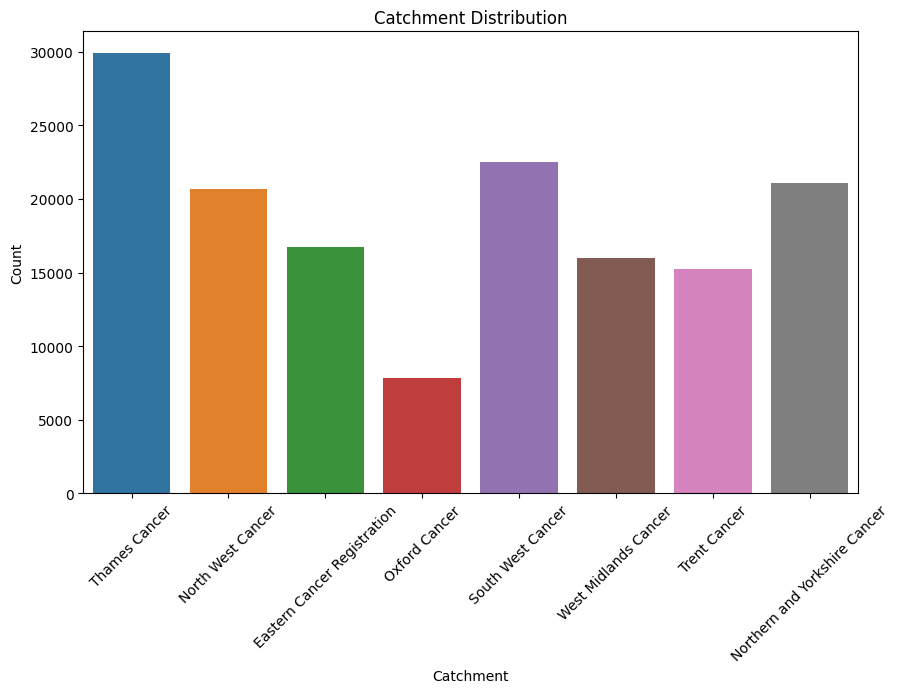

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='Catchment')
plt.xlabel('Catchment')
plt.ylabel('Count')
plt.title('Catchment Distribution')
plt.xticks(rotation=45)  # Adjust the rotation angle as needed
plt.show()

### ACE27

*   The Adult Comorbidity Evaluation 27 (ACE-27) is a validated comorbidity instrument that provides a score (0–3) based on the number and severity of medical comorbidities.
*   ACE27 scores range from 0 to3: 0 (no comorbidity), 1 (mild), 2 (moderate), and 3 (severe).
*   Replace missing values and 9 in the column with Not Known, and update it with appropriate description

In [ ]:
print('The unique values in Catchment:\n', data['ACE27'].value_counts(dropna=False))

ace_mapping = {
    '0': 'No comorbidity',
    '1': 'Mild',
    '2': 'Moderate',
    '3': 'Severe',
    '9': 'Not known',
    np.nan: 'Not known',
    '1m': 'Mild',
    '2m': 'Moderate',
    '3m': 'Severe'
}

data['ACE27'] = data['ACE27'].replace(ace_mapping)

print('=='*30)
print('The unique values in ACE27:\n', data['ACE27'].unique())

The unique values in Catchment:
 NaN    130822
9        7835
0        5829
1        2279
2        1569
3        1283
1m        168
2m        119
3m         96
Name: ACE27, dtype: int64
The unique values in ACE27:
 ['Not known' 'No comorbidity' 'Mild' 'Severe' 'Moderate']


### DATE_FIRST_SURGERY

*   DATE_FIRST_SURGERY is a date of an event (FIRST_SURGERY) that took place.
*   Replace missing value in DATE_FIRST_SURGERY with 0
*   Create a new column, Day_interval, update it with difference between the DATE_FIRST_SURGERY and VITALSTATUSDATE in days

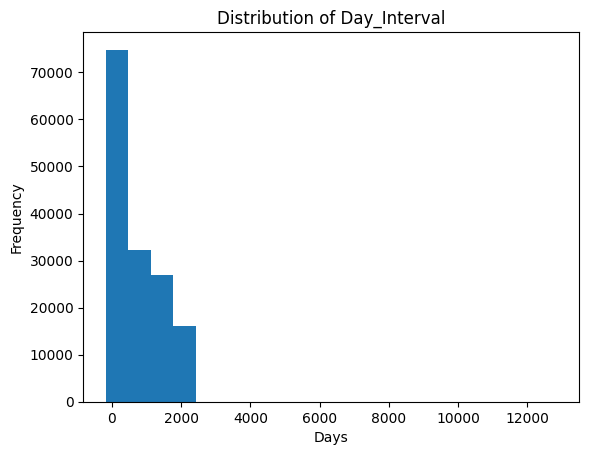

In [ ]:
# Convert 'DATE_FIRST_SURGERY' column to Timestamp type
#train_data['DATE_FIRST_SURGERY'] = pd.to_datetime(train_data['DATE_FIRST_SURGERY'], errors='coerce')

# Create a new column 'Day_Event' and calculate the difference in days
data['Day_Interval'] = (data['VITALSTATUSDATE'] - data['DATE_FIRST_SURGERY']).dt.days
data['Day_Interval'] = np.where(data['DATE_FIRST_SURGERY'].isnull(), 0, data['Day_Interval'])

# Plot the histogram
plt.hist(data['Day_Interval'], bins=20)
plt.xlabel('Days')
plt.ylabel('Frequency')
plt.title('Distribution of Day_Interval')
plt.show()

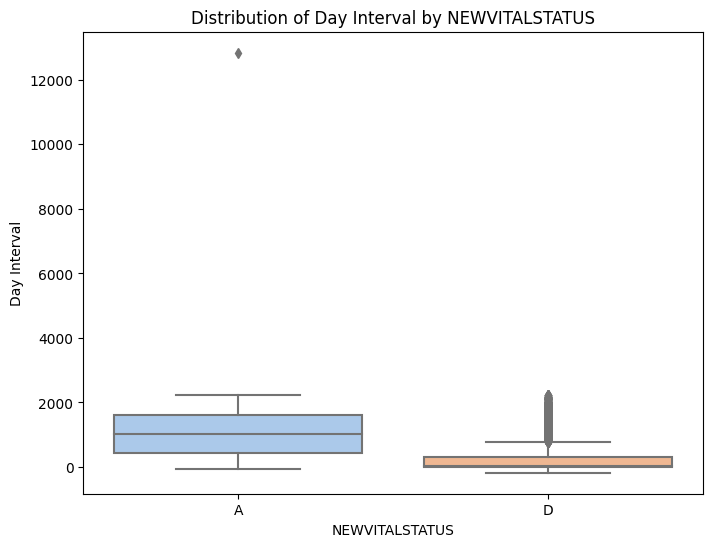

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.boxplot(data=data, x='NEWVITALSTATUS', y='Day_Interval', palette='pastel')
plt.xlabel('NEWVITALSTATUS')
plt.ylabel('Day Interval')
plt.title('Distribution of Day Interval by NEWVITALSTATUS')
plt.show()

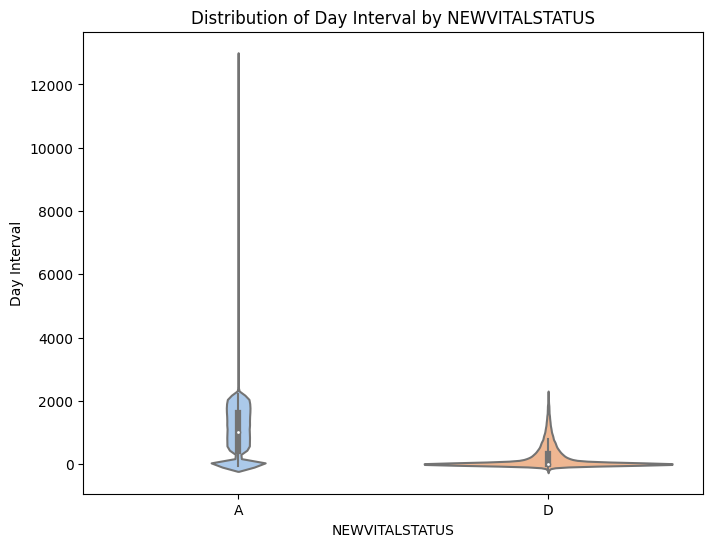

In [ ]:
plt.figure(figsize=(8, 6))
sns.violinplot(data=data, x='NEWVITALSTATUS', y='Day_Interval', palette='pastel')
plt.xlabel('NEWVITALSTATUS')
plt.ylabel('Day Interval')
plt.title('Distribution of Day Interval by NEWVITALSTATUS')
plt.show()

### CNS

*   This feature represents tha part of the brain with tumour secondary
*   Replace NaN, 99, NI, NN and NIm with Not Known
*   Update the feature as appropriate


In [ ]:
cns_locatn = data.CNS.value_counts()

cns_mapping = {
    '1': 'Frontal lobe',
    '2': 'Temporal lobe',
    '3': 'Parietal lobe',
    '4': 'Occipital lobe'
}

def replace_cns(value):
    if isinstance(value, str):
        if '1' in value:
            return cns_mapping['1']
        elif '2' in value:
            return cns_mapping['2']
        elif '3' in value:
            return cns_mapping['3']
        elif '4' in value:
            return cns_mapping['4']
    return 'Not Known'

data['CNS'] = data['CNS'].apply(replace_cns)

print('The counts of unique values in original CNS:\n', cns_locatn)
print('=='*25)
print('The counts of unique values in updated CNS:\n', data['CNS'].value_counts())

The counts of unique values in original CNS:
 Y1     23214
99     10455
Y2      3567
NI      1095
NN       316
Y1m      268
Y4       132
Y3        34
Y2m       34
Y4m        8
NIm        6
Name: CNS, dtype: int64
The counts of unique values in updated CNS:
 Not Known         122743
Frontal lobe       23482
Temporal lobe       3601
Occipital lobe       140
Parietal lobe         34
Name: CNS, dtype: int64


### Replace the code in LATERALITY, DEATHLOCATIONCODE and SITE_ICD10_O2_3CHAR with appropriate values

In [ ]:
# LATERALITY
data['LATERALITY'].replace({'L': 'Left', 'R': 'Right', 'M': 'Midline',
                            'B': 'Bilateral', '9': 'Not Known'}, inplace=True)

# DEATHLOCATIONCODE
data['deathlocation'] = data['DEATHLOCATIONCODE'].replace({'X': 'Unknown', '6': 'Unknown', '1': 'Hospital',
                                                           '2': 'Private Home', '3': 'Hospices', '4': 'Nursing Home',
                                                           '5': 'Others'}, inplace=True)

# SITE_ICD10_O2_3CHAR
data['tumour_site'] = data['SITE_ICD10_O2_3CHAR'].replace({'C50': 'Malignant cancer of breast',
                                                           'C34': 'Malignant cancer of lungs and bronchus',
                                                           'C20': 'Malignant cancer of rectum',
                                                           'C18': 'Malignant cancer of colon',
                                                           'C19': 'Malignant cancer of rectosigmoid junction',
                                                           'C33': 'Malignant cancer of trachea'}, inplace=True)

In [ ]:
#@title Remove redundant features

def drop_features(data):
    features_to_drop = [
        'ETHNICITY',
        'SITE_ICD10_O2',
        'MORPH_ICD10_O2',
        'BEHAVIOUR_ICD10_O2',
        'Histology Code',
        'GRADE',
        'DEATHCAUSECODE_1A',
        'DEATHCAUSECODE_1B',
        'DEATHCAUSECODE_1C',
        'DEATHCAUSECODE_2',
        'DEATHCAUSECODE_UNDERLYING',
        'VITALSTATUSDATE',
        'DIAGNOSISDATEBEST',
        'T_BEST',
        'N_BEST',
        'M_BEST',
        'STAGE_BEST',
        'STAGE_BEST_SYSTEM',
        'ER_SCORE',
        'PR_SCORE',
        'SCREENINGSTATUSFULL_CODE',
        'CREG_CODE',
        'DEATHLOCATIONCODE',
        'SITE_ICD10_O2_3CHAR',
        'DATE_FIRST_SURGERY'
    ]
    data.drop(columns=features_to_drop, inplace=True)

# Example usage:
drop_features(data)

In [ ]:
column_order = ['PATIENTID', 'AGE', 'SEX', 'ethnicity_group', 'ER_STATUS', 'PR_STATUS', 'HER2_STATUS',
                'Histology_types', 'Grading', 'Time_Difference', 'Staging', 'Screening_status', 'Catchment',
                'Day_Interval', 'CANCERCAREPLANINTENT', 'PERFORMANCESTATUS', 'CNS', 'ACE27', 'LATERALITY', 'QUINTILE_2015',
                'tumour_site', 'deathlocation', 'NEWVITALSTATUS']

data = data[column_order]
data.head()

,PATIENTID,AGE,SEX,ethnicity_group,ER_STATUS,PR_STATUS,HER2_STATUS,Histology_types,Grading,Time_Difference,...,Day_Interval,CANCERCAREPLANINTENT,PERFORMANCESTATUS,CNS,ACE27,LATERALITY,QUINTILE_2015,tumour_site,deathlocation,NEWVITALSTATUS
0,20011904,61,Female,Non-white,Negative,Negative,Negative,Malignant,Poorly differentiated,2143,...,1713.0,Not Known,Not Known,Frontal lobe,Not known,Left,1 - least deprived,None,None,A
1,40016070,90,Female,White,Not Performed/Not Known,Not Performed/Not Known,Not Performed/Not Known,Malignant,Not Assessed/Appropriate,137,...,0.0,Non-Curative,Restricted Activity,Not Known,Not known,Right,5 - most deprived,None,None,D
2,20203163,66,Female,White,Positive,Not Performed/Not Known,Negative,Malignant,Moderately differentiated,578,...,555.0,Not Known,Not Known,Not Known,Not known,Right,2,None,None,A
3,40156705,71,Male,White,Not Performed/Not Known,Not Performed/Not Known,Not Performed/Not Known,Malignant,Moderately differentiated,330,...,330.0,Not Known,Not Known,Not Known,Not known,Right,4,None,None,D
4,20051096,68,Female,White,Not Performed/Not Known,Not Performed/Not Known,Borderline,Malignant,Moderately differentiated,1152,...,1131.0,Curative,Full Activity,Not Known,No comorbidity,Left,3,None,None,A


In [ ]:
data.head()

,PATIENTID,AGE,SEX,ethnicity_group,ER_STATUS,PR_STATUS,HER2_STATUS,Histology_types,Grading,Time_Difference,...,Day_Interval,CANCERCAREPLANINTENT,PERFORMANCESTATUS,CNS,ACE27,LATERALITY,QUINTILE_2015,tumour_site,deathlocation,NEWVITALSTATUS
0,20011904,61,Female,Non-white,Negative,Negative,Negative,Malignant,Poorly differentiated,2143,...,1713.0,Not Known,Not Known,Frontal lobe,Not known,Left,1 - least deprived,None,None,A
1,40016070,90,Female,White,Not Performed/Not Known,Not Performed/Not Known,Not Performed/Not Known,Malignant,Not Assessed/Appropriate,137,...,0.0,Non-Curative,Restricted Activity,Not Known,Not known,Right,5 - most deprived,None,None,D
2,20203163,66,Female,White,Positive,Not Performed/Not Known,Negative,Malignant,Moderately differentiated,578,...,555.0,Not Known,Not Known,Not Known,Not known,Right,2,None,None,A
3,40156705,71,Male,White,Not Performed/Not Known,Not Performed/Not Known,Not Performed/Not Known,Malignant,Moderately differentiated,330,...,330.0,Not Known,Not Known,Not Known,Not known,Right,4,None,None,D
4,20051096,68,Female,White,Not Performed/Not Known,Not Performed/Not Known,Borderline,Malignant,Moderately differentiated,1152,...,1131.0,Curative,Full Activity,Not Known,No comorbidity,Left,3,None,None,A


##  Cap and floor data to remove outliers

In [ ]:
data.describe()

,PATIENTID,AGE,Time_Difference,Day_Interval
count,1.500000e+05,150000.000000,150000.00000,150000.000000
mean,4.297142e+07,68.216907,937.55196,674.226713
std,3.529068e+07,13.778466,665.97865,707.074049
min,2.000000e+07,1.000000,0.00000,-180.000000
25%,2.013057e+07,59.000000,342.00000,0.000000
50%,4.005524e+07,69.000000,847.00000,474.000000
75%,6.002341e+07,79.000000,1500.25000,1247.000000
max,3.300249e+08,105.000000,2231.00000,12842.000000


In [ ]:
#@title Detect outliers with Z-score
def detect_outlier(feature):
    outliers = []
    dat = data[feature]
    mean = np.mean(dat)
    std = np.std(dat)

    for y in dat:
        z_score = (y - mean)/std
        if np.abs(z_score) > 3:
            outliers.append(y)
    print('\nOutlier caps for {}:'.format(feature))
    print('    --95p: {:.1f} / {} values exceed that'.format(dat.quantile(.95), len([i for i in dat if i > dat.quantile(.95)])))
    print('    --3sd: {:.1f} / {} values exceed that'.format(mean + 3*(std), len(outliers)))
    print('    --99p: {:.1f} / {} values exceed that'.format(dat.quantile(.99), len([i for i in dat if i > dat.quantile(.99)])))

In [ ]:
# Determine what the upperbound should be for continous features

for feature in ['AGE', 'Time_Difference', 'Day_Interval']:
    detect_outlier(feature)


Outlier caps for AGE:
    --95p: 89.0 / 5914 values exceed that
    --3sd: 109.6 / 361 values exceed that
    --99p: 94.0 / 1087 values exceed that

Outlier caps for Time_Difference:
    --95p: 2079.0 / 7484 values exceed that
    --3sd: 2935.5 / 0 values exceed that
    --99p: 2200.0 / 1463 values exceed that

Outlier caps for Day_Interval:
    --95p: 1996.0 / 7497 values exceed that
    --3sd: 2795.4 / 2 values exceed that
    --99p: 2164.0 / 1483 values exceed that


In [ ]:
#@title Cap features with 99 percentiles
data['AGE'].clip(upper = data['AGE'].quantile(.99), inplace=True)
data['Time_Difference'].clip(upper = data['Time_Difference'].quantile(.99), inplace=True)
data['Day_Interval'].clip(upper = data['Day_Interval'].quantile(.99), inplace=True)

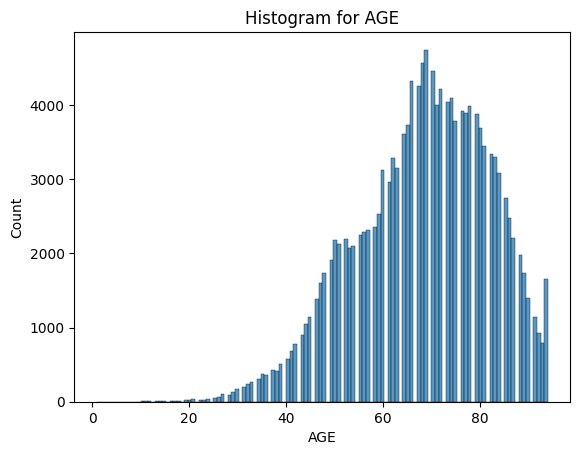

In [ ]:
# Plot histogram for each continuous feature to see if a transformation is necessary

for feature in ['AGE']:
    sns.histplot(data=data, x=feature, kde=False)
    plt.title('Histogram for {}'.format(feature))
    plt.show()

<ipython-input-94-7eb4e3c0c42d>:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



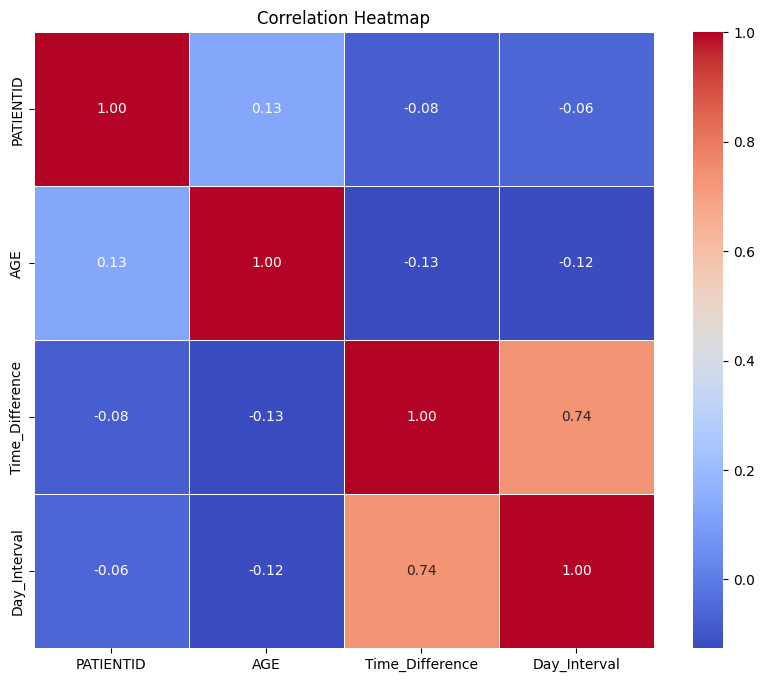

In [ ]:
# Calculate the correlation matrix
correlation_matrix = data.corr()

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

## Convert categorical features to numeric levels

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

In [ ]:
#@title Check for categorical features in the data

cat_features = [i for i in data.columns if (data[i].dtype == 'O')]

print(len(cat_features))
cat_features

19


['SEX',
 'ethnicity_group',
 'ER_STATUS',
 'PR_STATUS',
 'HER2_STATUS',
 'Histology_types',
 'Grading',
 'Staging',
 'Screening_status',
 'Catchment',
 'CANCERCAREPLANINTENT',
 'PERFORMANCESTATUS',
 'CNS',
 'ACE27',
 'LATERALITY',
 'QUINTILE_2015',
 'tumour_site',
 'deathlocation',
 'NEWVITALSTATUS']

### Categorical Features separated into two
*   Nominal: 'SEX', 'ethnicity_group', 'Screening_status', 'Catchment', 'tumour_site', 'deathlocation', 'CNS' and 'LATERALITY'
*   Ordinal: 'ER_STATUS', 'PR_STATUS', 'HER2_STATUS', 'Histology_types', 'Grading', 'Staging', 'CANCERCAREPLANINTENT', 'PERFORMANCESTATUS', 'ACE27' and 'QUINTILE_2015'



In [ ]:
#@title Convert categorical variable to numeric levels
# Nominal Features (One-hot encoding)
nominal_features = ['SEX', 'ethnicity_group', 'Screening_status', 'Catchment', 'tumour_site',
                    'deathlocation', 'CNS', 'LATERALITY']
data = pd.get_dummies(data, columns=nominal_features)

# Ordinal Features (Label encoding)
ordinal_features = ['ER_STATUS', 'PR_STATUS', 'HER2_STATUS', 'Histology_types', 'Grading', 'Staging',
                    'CANCERCAREPLANINTENT', 'PERFORMANCESTATUS', 'ACE27', 'QUINTILE_2015']
label_encoder = LabelEncoder()
for feature in ordinal_features:
    data[feature] = label_encoder.fit_transform(data[feature])

# Now, 'train_data' DataFrame will have the nominal features encoded using one-hot encoding
# and ordinal features encoded using label encoding.

In [ ]:
#@title Map the values in the 'NEWVITALSTATUS' column to numeric values
# Create a mapping dictionary
vitalstatus_mapping = {'A': 1, 'D': 0}

# Map the values in the 'NEWVITALSTATUS' column to numeric values
data['NEWVITALSTATUS'] = data['NEWVITALSTATUS'].map(vitalstatus_mapping)

# Display the updated train_data
data['NEWVITALSTATUS'].unique()

array([ 1.,  0., nan])

In [ ]:
data.head()

,PATIENTID,AGE,ER_STATUS,PR_STATUS,HER2_STATUS,Histology_types,Grading,Time_Difference,Staging,Day_Interval,...,CNS_Frontal lobe,CNS_Not Known,CNS_Occipital lobe,CNS_Parietal lobe,CNS_Temporal lobe,LATERALITY_Bilateral,LATERALITY_Left,LATERALITY_Midline,LATERALITY_Not Known,LATERALITY_Right
0,20011904,61,1,1,1,0,2,2143,5,1713.0,...,1,0,0,0,0,0,1,0,0,0
1,40016070,90,2,2,2,0,1,137,7,0.0,...,0,1,0,0,0,0,0,0,0,1
2,20203163,66,3,2,1,0,0,578,4,555.0,...,0,1,0,0,0,0,0,0,0,1
3,40156705,71,2,2,2,0,0,330,7,330.0,...,0,1,0,0,0,0,0,0,0,1
4,20051096,68,2,2,0,0,0,1152,5,1131.0,...,0,1,0,0,0,0,1,0,0,0


## Split the data into train and test data


In [ ]:
#@title Split the data into train and test dta

# Split data into train and test sets
train_data = data[:100000]
test_data = data[100000:]

# Verify the shapes of the train and test sets
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (100000, 43)
Test data shape: (50000, 43)


In [ ]:
#@title Drop PatientID
train_data.drop(['PATIENTID'], axis ='columns', inplace= True)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 42 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   AGE                                      100000 non-null  int64  
 1   ER_STATUS                                100000 non-null  int64  
 2   PR_STATUS                                100000 non-null  int64  
 3   HER2_STATUS                              100000 non-null  int64  
 4   Histology_types                          100000 non-null  int64  
 5   Grading                                  100000 non-null  int64  
 6   Time_Difference                          100000 non-null  int64  
 7   Staging                                  100000 non-null  int64  
 8   Day_Interval                             100000 non-null  float64
 9   CANCERCAREPLANINTENT                     100000 non-null  int64  
 10  PERFORMANCESTATUS                

<ipython-input-103-b2993f83a543>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
index_col = test_data['PATIENTID']
test_data.drop(['PATIENTID'], axis ='columns', inplace= True)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 100000 to 149999
Data columns (total 42 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   AGE                                      50000 non-null  int64  
 1   ER_STATUS                                50000 non-null  int64  
 2   PR_STATUS                                50000 non-null  int64  
 3   HER2_STATUS                              50000 non-null  int64  
 4   Histology_types                          50000 non-null  int64  
 5   Grading                                  50000 non-null  int64  
 6   Time_Difference                          50000 non-null  int64  
 7   Staging                                  50000 non-null  int64  
 8   Day_Interval                             50000 non-null  float64
 9   CANCERCAREPLANINTENT                     50000 non-null  int64  
 10  PERFORMANCESTATUS                       

<ipython-input-104-0cf50bb8d345>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
y = train_data['NEWVITALSTATUS']
X = train_data.drop(['NEWVITALSTATUS'], axis = 1)

test_data = test_data.drop(['NEWVITALSTATUS'], axis = 1)

In [ ]:
print(y.shape, X.shape, test_data.shape)

(100000,) (100000, 41) (50000, 41)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## Standardize all features

In [ ]:
from sklearn.preprocessing import StandardScaler

# creating a standard scaler
sc = StandardScaler()

# feeding independents sets into the standard scaler
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

(80000, 41)
(20000, 41)
(80000,)


In [ ]:
y.value_counts()

1.0    58594
0.0    41406
Name: NEWVITALSTATUS, dtype: int64

## LogisticRegression

In [ ]:
from sklearn.linear_model import LogisticRegression

# Create the model with class weights
class_weights = {0: 5, 1: 1}  # You can adjust the weight values based on your data
log_model = LogisticRegression(class_weight=class_weights)

# Train the model
log_model.fit(X_train, y_train)

LogisticRegression(class_weight={0: 5, 1: 1})

In [ ]:
ypred_log = log_model.predict(X_test)
print(ypred_log)

[0. 0. 1. ... 0. 1. 1.]


## RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Create the model with class weights
class_weights = {0: 5, 1: 1}  # You can adjust the weight values based on your data
RFC_model = RandomForestClassifier(class_weight=class_weights)

# Train the model
RFC_model.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 5, 1: 1})

In [ ]:
ypred_RFC = RFC_model.predict(X_test)
print(ypred_RFC)

[0. 1. 1. ... 1. 1. 1.]


Gradient Boosting (e.g., XGBoost, LightGBM):

In [ ]:
import xgboost as xgb

# Create the model with class weights
params = {'objective': 'binary:logistic', 'scale_pos_weight': 0.2}   # Adjust the weight value
xgb_model = xgb.XGBClassifier(**params)

# Train the model
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
ypred_xgb = xgb_model.predict(X_test)
print(ypred_xgb)

[0 1 1 ... 1 1 0]


## LIGHTGBM

In [ ]:
import lightgbm as lgb

# Calculate the class weights based on the distribution of the target variable
class_weights = (1 / y_train.value_counts(normalize=True)).to_dict()

# Create the LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)

# Create the LightGBM model with class weights using the 'scale_pos_weight' parameter
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'scale_pos_weight': class_weights[1],  # Use the class weight for the positive class (class 1)
}

lgb_model = lgb.train(params, train_data, num_boost_round=100)

[LightGBM] [Info] Number of positive: 46882, number of negative: 33118
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022154 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 732
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.586025 -> initscore=0.347557
[LightGBM] [Info] Start training from score 0.347557


In [ ]:
# Make predictions on the test set
y_predlgb = lgb_model.predict(X_test)

# Threshold the probabilities to get the predicted classes (0 or 1)
y_predlgb_class = (y_predlgb > 0.5).astype(int)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report

def evaluate_model(name, y_test, y_pred):
    """
    Evaluate the performance of a model and print the evaluation metrics.

    Args:
        name (str): Name of the model.
        y_test (array-like): True labels of the test set.
        y_pred (array-like): Predicted labels of the test set.
    """

    accuracy = round(accuracy_score(y_test, y_pred), 3)
    precision = round(precision_score(y_test, y_pred), 3)
    recall = round(recall_score(y_test, y_pred), 3)
    conf_matrix = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print('{}  --\tAccuracy: {} / Precision: {} / Recall: {}'.format(name, accuracy, precision, recall))
    print("Confusion Matrix:\n", conf_matrix)
    print("Classification Report:\n", report)


In [ ]:
evaluate_model(log_model, y_test, ypred_log)
evaluate_model(RFC_model, y_test, ypred_RFC)
evaluate_model(xgb_model, y_test, ypred_xgb)
evaluate_model(lgb_model, y_test, y_predlgb_class)

LogisticRegression(class_weight={0: 5, 1: 1})  --	Accuracy: 0.762 / Precision: 0.939 / Recall: 0.634
Confusion Matrix:
 [[7806  482]
 [4282 7430]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.65      0.94      0.77      8288
         1.0       0.94      0.63      0.76     11712

    accuracy                           0.76     20000
   macro avg       0.79      0.79      0.76     20000
weighted avg       0.82      0.76      0.76     20000

RandomForestClassifier(class_weight={0: 5, 1: 1})  --	Accuracy: 0.902 / Precision: 0.882 / Recall: 0.961
Confusion Matrix:
 [[ 6780  1508]
 [  459 11253]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.82      0.87      8288
         1.0       0.88      0.96      0.92     11712

    accuracy                           0.90     20000
   macro avg       0.91      0.89      0.90     20000
weighted avg       0.90      0.90      0.90     200

In [ ]:
pred_RFC = RFC_model.predict(test_data.values)

submission = pd.DataFrame({'PATIENTID':index_col,'NEWVITALSTATUS':pred_RFC})

# Save results
submission.to_csv( path + "submission_randomforest.csv", index=False)

In [ ]:
pred_lgb = lgb_model.predict(test_data.values)

# Threshold the probabilities to get the predicted classes (0 or 1)
predlgb_class = (pred_lgb > 0.5).astype(int)

submission = pd.DataFrame({'PATIENTID':index_col,'NEWVITALSTATUS':predlgb_class})

# Save results
submission.to_csv(path + "submission_lightgbm.csv", index=False)